In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import re
import sys
import pickle
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from data_loader import get_loader
from torchvision import transforms
from margin_exp import train_model, plot
from network import ResNet18, CNN
import seaborn as sns
from utils import ramp_loss, margin_error

use_gpu = torch.cuda.is_available()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_01, log_01 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

Epoch 1/100
----------
train1: CrossEntropy: 1.4366, Error: 0.4699, Lip(PowIter):5.6017
test: CrossEntropy: 1.5086, Error: 0.4979, Lip(PowIter):5.6017
Epoch 2/100
----------
train1: CrossEntropy: 1.1981, Error: 0.3783, Lip(PowIter):4.0926
test: CrossEntropy: 1.3543, Error: 0.4338, Lip(PowIter):4.0926
Epoch 3/100
----------
train1: CrossEntropy: 1.0208, Error: 0.3068, Lip(PowIter):4.1939
test: CrossEntropy: 1.2951, Error: 0.4053, Lip(PowIter):4.1939
Epoch 4/100
----------
train1: CrossEntropy: 0.9072, Error: 0.2713, Lip(PowIter):4.5249
test: CrossEntropy: 1.3315, Error: 0.4155, Lip(PowIter):4.5249
Epoch 5/100
----------
train1: CrossEntropy: 0.6966, Error: 0.1945, Lip(PowIter):5.2461
test: CrossEntropy: 1.3141, Error: 0.4018, Lip(PowIter):5.2461
Epoch 6/100
----------
train1: CrossEntropy: 0.5548, Error: 0.1559, Lip(PowIter):6.0186
test: CrossEntropy: 1.3676, Error: 0.4055, Lip(PowIter):6.0186
Epoch 7/100
----------
train1: CrossEntropy: 0.4452, Error: 0.1226, Lip(PowIter):7.1086
test: 

test: CrossEntropy: 2.1127, Error: 0.4104, Lip(PowIter):15.3935
Epoch 55/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.5547
test: CrossEntropy: 2.1099, Error: 0.4109, Lip(PowIter):15.5547
Epoch 56/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.5385
test: CrossEntropy: 2.1098, Error: 0.4078, Lip(PowIter):15.5385
Epoch 57/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.4481
test: CrossEntropy: 2.1069, Error: 0.4096, Lip(PowIter):15.4481
Epoch 58/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.6173
test: CrossEntropy: 2.1308, Error: 0.4081, Lip(PowIter):15.6173
Epoch 59/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.4355
test: CrossEntropy: 2.1237, Error: 0.4098, Lip(PowIter):15.4355
Epoch 60/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.8987
test: CrossEntropy: 2.1313, Error: 0.4122, Lip(PowIter):15.8987
Epoch 61/100

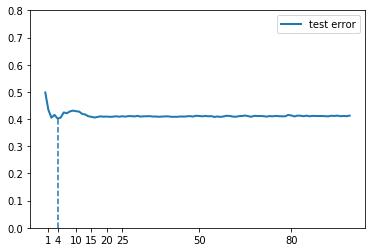

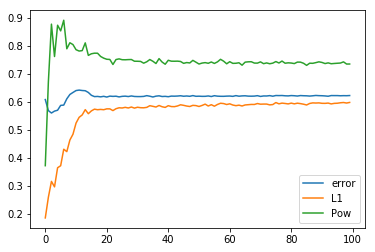

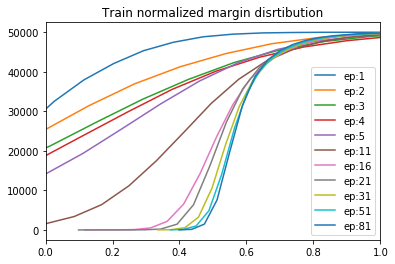

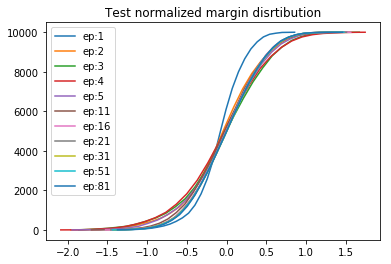

In [34]:
log = log_01

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 0.9
plt.plot(log_03['test_error'], label='error')
nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.xlim(0,1)
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


In [32]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_00, log_00 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: original ******
total parameters: 5780810
Epoch 1/100
----------
train1: CrossEntropy: 1.1780, Error: 0.4091, Lip(PowIter):4.8002
test: CrossEntropy: 1.2657, Error: 0.4464, Lip(PowIter):4.8002
Epoch 2/100
----------
train1: CrossEntropy: 0.9175, Error: 0.3115, Lip(PowIter):4.4180
test: CrossEntropy: 1.0946, Error: 0.3923, Lip(PowIter):4.4180
Epoch 3/100
----------
train1: CrossEntropy: 0.6729, Error: 0.2221, Lip(PowIter):4.1056
test: CrossEntropy: 0.9440, Error: 0.3312, Lip(PowIter):4.1056
Epoch 4/100
----------
train1: CrossEntropy: 0.5277, Error: 0.1663, Lip(PowIter):4.8689
test: CrossEntropy: 0.9230, Error: 0.3202, Lip(PowIter):4.8689
Epoch 5/100
----------
train1: CrossEntropy: 0.4865, Error: 0.1584, Lip(PowIter):5.4596
test: CrossEntropy: 1.0268, Error: 0.3588, Lip(PowIter):5.4596
Epoch 6/100
----------
train1: CrossEntropy: 0.3209, Error: 0.0976, Lip(PowIter):6.3777
test: CrossEntropy: 0.9815, Error: 0.3198, Lip(PowIter):6.3777
Epoch 7/100
----------
train1: Cr

train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.0538
test: CrossEntropy: 1.2518, Error: 0.2941, Lip(PowIter):15.0538
Epoch 55/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.0612
test: CrossEntropy: 1.2547, Error: 0.2941, Lip(PowIter):15.0612
Epoch 56/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.0731
test: CrossEntropy: 1.2607, Error: 0.2961, Lip(PowIter):15.0731
Epoch 57/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.2887
test: CrossEntropy: 1.2686, Error: 0.2965, Lip(PowIter):15.2887
Epoch 58/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.4072
test: CrossEntropy: 1.2675, Error: 0.2950, Lip(PowIter):15.4072
Epoch 59/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):15.2173
test: CrossEntropy: 1.2674, Error: 0.2946, Lip(PowIter):15.2173
Epoch 60/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):15.2898
test: Cros

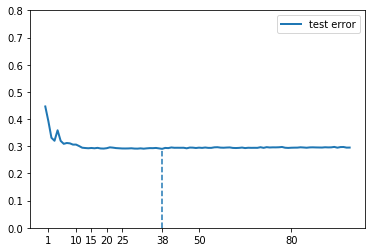

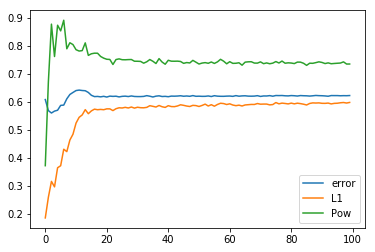

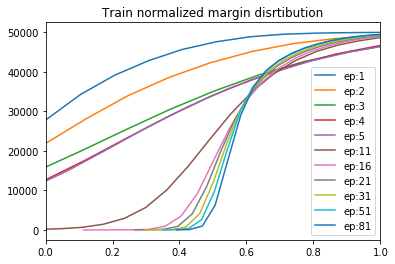

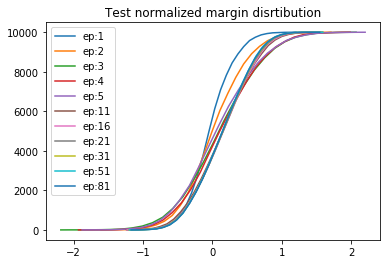

In [36]:
log = log_00

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 0.9
plt.plot(log_03['test_error'], label='error')
nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.xlim(0,1)
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


In [33]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.3'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_03, log_03 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: partially-0.3 ******
total parameters: 5780810
Epoch 1/100
----------
train1: CrossEntropy: 1.7791, Error: 0.5693, Lip(PowIter):3.1355
test: CrossEntropy: 1.8626, Error: 0.6078, Lip(PowIter):3.1355
Epoch 2/100
----------
train1: CrossEntropy: 1.6298, Error: 0.4990, Lip(PowIter):2.5458
test: CrossEntropy: 1.8034, Error: 0.5683, Lip(PowIter):2.5458
Epoch 3/100
----------
train1: CrossEntropy: 1.4895, Error: 0.4561, Lip(PowIter):2.5769
test: CrossEntropy: 1.7896, Error: 0.5597, Lip(PowIter):2.5769
Epoch 4/100
----------
train1: CrossEntropy: 1.3482, Error: 0.3982, Lip(PowIter):3.0468
test: CrossEntropy: 1.8089, Error: 0.5665, Lip(PowIter):3.0468
Epoch 5/100
----------
train1: CrossEntropy: 1.1581, Error: 0.3479, Lip(PowIter):3.5775
test: CrossEntropy: 1.8669, Error: 0.5697, Lip(PowIter):3.5775
Epoch 6/100
----------
train1: CrossEntropy: 0.9985, Error: 0.2959, Lip(PowIter):4.0843
test: CrossEntropy: 1.9531, Error: 0.5870, Lip(PowIter):4.0843
Epoch 7/100
----------
train

train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.7840
test: CrossEntropy: 3.5424, Error: 0.6207, Lip(PowIter):14.7840
Epoch 55/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.7942
test: CrossEntropy: 3.5581, Error: 0.6187, Lip(PowIter):14.7942
Epoch 56/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.7427
test: CrossEntropy: 3.5432, Error: 0.6216, Lip(PowIter):14.7427
Epoch 57/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.7877
test: CrossEntropy: 3.5697, Error: 0.6200, Lip(PowIter):14.7877
Epoch 58/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.5647
test: CrossEntropy: 3.5625, Error: 0.6195, Lip(PowIter):14.5647
Epoch 59/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.7895
test: CrossEntropy: 3.5707, Error: 0.6194, Lip(PowIter):14.7895
Epoch 60/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(PowIter):14.9434
test: Cros

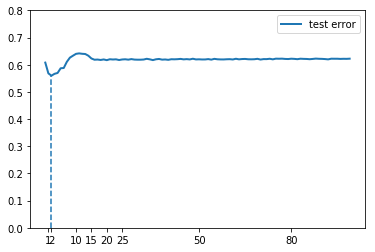

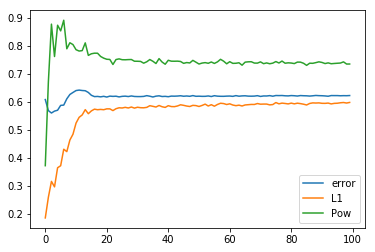

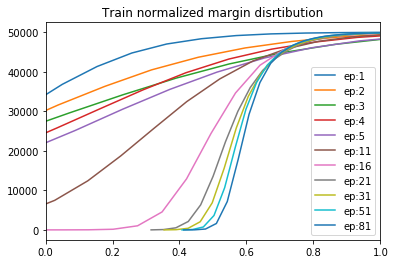

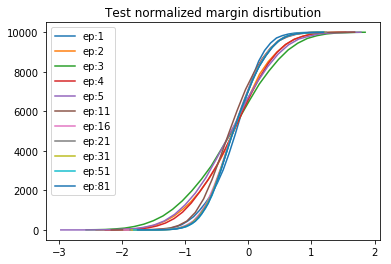

In [37]:
log = log_03

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 0.9
plt.plot(log_03['test_error'], label='error')
nmargin_l1 = np.array(log_03['train_dist_margin'])/np.array(log_03['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log_03['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.xlim(0,1)
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()


In [3]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.3'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 800
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_03_2, log_03_2 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: partially-0.3 ******
total parameters: 23081610
Epoch 1/100
----------
train1: CrossEntropy: 1.7379, Error: 0.5551, Lip(PowIter):3.5041
test: CrossEntropy: 1.8224, Error: 0.5952, Lip(PowIter):3.5041
Epoch 2/100
----------
train1: CrossEntropy: 1.5878, Error: 0.4880, Lip(PowIter):2.8267
test: CrossEntropy: 1.7991, Error: 0.5670, Lip(PowIter):2.8267
Epoch 3/100
----------
train1: CrossEntropy: 1.4052, Error: 0.4236, Lip(PowIter):2.8319
test: CrossEntropy: 1.7963, Error: 0.5588, Lip(PowIter):2.8319
Epoch 4/100
----------
train1: CrossEntropy: 1.1821, Error: 0.3491, Lip(PowIter):3.2379
test: CrossEntropy: 1.8262, Error: 0.5646, Lip(PowIter):3.2379
Epoch 5/100
----------
train1: CrossEntropy: 0.9307, Error: 0.2759, Lip(PowIter):3.8973
test: CrossEntropy: 1.9150, Error: 0.5664, Lip(PowIter):3.8973
Epoch 6/100
----------
train1: CrossEntropy: 0.6909, Error: 0.1965, Lip(PowIter):4.7370
test: CrossEntropy: 2.0417, Error: 0.5917, Lip(PowIter):4.7370
Epoch 7/100
----------
trai

train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.0412
test: CrossEntropy: 3.2268, Error: 0.5906, Lip(PowIter):12.0412
Epoch 55/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.1804
test: CrossEntropy: 3.2259, Error: 0.5912, Lip(PowIter):12.1804
Epoch 56/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.2186
test: CrossEntropy: 3.2328, Error: 0.5921, Lip(PowIter):12.2186
Epoch 57/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.2211
test: CrossEntropy: 3.2413, Error: 0.5916, Lip(PowIter):12.2211
Epoch 58/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.2446
test: CrossEntropy: 3.2480, Error: 0.5918, Lip(PowIter):12.2446
Epoch 59/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.1488
test: CrossEntropy: 3.2424, Error: 0.5919, Lip(PowIter):12.1488
Epoch 60/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(PowIter):12.1237
test: Cros

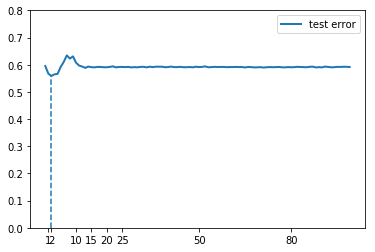

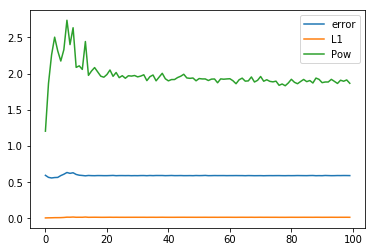

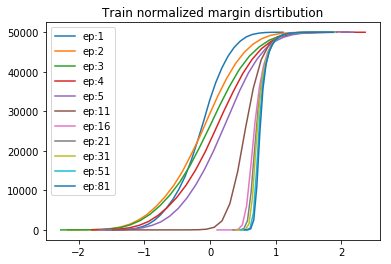

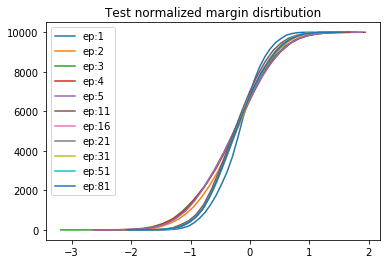

In [8]:
log = log_03_2

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.0
plt.plot(log['test_error'], label='error')
nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1, q, axis=1)*100, label='L1')
plt.plot(log['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Train normalized margin disrtibution')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('Test normalized margin disrtibution')
plt.show()
